# Sentiment Analysis with VADER
by: Heather Robbins

#### What is Sentiment Analysis?
- Sentiment Analysis is the process of computationally determining whether a piece of text is positive, negative or neutral.
- There are a variety of tools out there to perform sentiment analysis https://www.iflexion.com/blog/sentiment-analysis-python
- Today we're going to focus on the VADER Sentiment Intensity Analyzer from NLTK.

<img src="https://media.giphy.com/media/3ohuPsd2QJlKWmhgSk/giphy.gif" style="float: center; margin: 20px; height: 300px">

### VADER (Valence Aware Dictionary and sEntiment Reasoner):
is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

### Advantages of using VADER

VADER has a lot of advantages over some traditional methods of Sentiment Analysis, including:

- It works exceedingly well on social media type text, yet readily generalizes to multiple domains
- It is fast enough to be used online with streaming data, and
- It does not severely suffer from a speed-performance tradeoff.
- It takes punctuation and capitalization into account
- It can interpret emojis 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# easier to see full text with a bigger maxwidth:
pd.options.display.max_colwidth = 200

## Load in the text data:

This data is from Kaggle: https://www.kaggle.com/c/nlp-getting-started

In [2]:
tweets = pd.read_csv('data/disaster_train.csv')

In [3]:
tweets.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


Our target column denotes whether a tweet is about a real disaster (1) or not (0)

In [4]:
#get rid of unnecessary columns

tweets = tweets[['text', 'target']]

In [5]:
tweets.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


#### Quick Clean Up

In [6]:
tweets['text'] = tweets['text'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('\n\n\S+', '', regex=True)

In [7]:
tweets.head()

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


Regex Cheatsheet: https://www.debuggex.com/cheatsheet/regex/python

## Format tweets for VADER:

The `SentimentIntensityAnalyzer` will expect a list of strings.

In [9]:
#convert to a list of strings:

corpus = list(tweets['text'])
corpus[:10]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires',
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas',
 "I'm on top of the hill and I can see a fire in the woods...",
 "There's an emergency evacuation happening now in the building across the street",
 "I'm afraid that the tornado is coming to our area..."]

## Instantiate `SentimentIntensityAnalyzer` and test it on the first tweet:

In [10]:
#instantiate SIA

sia = SentimentIntensityAnalyzer()


#Get polarity scores for the first tweet

sia.polarity_scores(corpus[0])


{'neg': 0.0, 'neu': 0.851, 'pos': 0.149, 'compound': 0.2732}

In [11]:
corpus[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

- The 'compound' score is computed by summing the scores of each word and then is normalized to be between -1 (most extreme negative) and +1 (most extreme positive). 
- This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. 
- Calling it a 'normalized, weighted composite score' is accurate.

Generally:
- positive sentiment : (compound score >= 0.05)
- neutral sentiment : (compound score > -0.05) and (compound score < 0.05)
- negative sentiment : (compound score <= -0.05)

## Dataframe of sentiment analyses:

In [12]:
#create dataframe that contains text and the polarity scores for each tweet

sentiment = []    

for tweet in corpus:
    scores = sia.polarity_scores(tweet)
    scores['text'] = tweet
    sentiment.append(scores)

df = pd.DataFrame(sentiment)
df.head()

,compound,neg,neu,pos,text
0,0.2732,0.000,0.851,0.149,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
1,-0.3400,0.286,0.714,0.000,Forest fire near La Ronge Sask. Canada
2,-0.2960,0.095,0.905,0.000,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
3,0.0000,0.000,1.000,0.000,"13,000 people receive #wildfires evacuation orders in California"
4,0.0000,0.000,1.000,0.000,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school


## Add back Target:

In [13]:
df['target'] = tweets['target']

In [14]:
df.head()

,compound,neg,neu,pos,text,target
0,0.2732,0.000,0.851,0.149,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,-0.3400,0.286,0.714,0.000,Forest fire near La Ronge Sask. Canada,1
2,-0.2960,0.095,0.905,0.000,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,0.0000,0.000,1.000,0.000,"13,000 people receive #wildfires evacuation orders in California",1
4,0.0000,0.000,1.000,0.000,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


## Investigating polarities:

#### Looking at positive and negative text for Real Disasters

In [15]:
df1 =df[df['target'] == 1]

In [16]:
df1.head()

,compound,neg,neu,pos,text,target
0,0.2732,0.000,0.851,0.149,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,-0.3400,0.286,0.714,0.000,Forest fire near La Ronge Sask. Canada,1
2,-0.2960,0.095,0.905,0.000,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,0.0000,0.000,1.000,0.000,"13,000 people receive #wildfires evacuation orders in California",1
4,0.0000,0.000,1.000,0.000,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [18]:
df1.sort_values(by = 'pos', ascending = False).head(10)

,compound,neg,neu,pos,text,target
5887,0.6449,0.000,0.319,0.681,SANDSTORM!!! WOO HOO!!,1
1567,0.8834,0.000,0.347,0.653,ok peace I hope I fall off a cliff along with my dignity,1
2457,0.9356,0.000,0.425,0.575,@Raishimi33 :) well I think that sounds like a fine plan where little derailment is possible so I applaud you :),1
625,0.8316,0.000,0.443,0.557,CDC has a pretty cool list of all bioterrorism agents :3,1
6772,0.3612,0.000,0.444,0.556,I feel like a tornado,1
3488,0.7269,0.000,0.450,0.550,@lordRsBiscuits That's always good for a pretty explosion.,1
5609,0.8625,0.000,0.455,0.545,George Njenga the hero saved his burning friend from a razing wildfire...,1
5601,0.8625,0.000,0.455,0.545,George Njenga the hero saved his burning friend from a razing wildfire,1
5030,0.5362,0.000,0.464,0.536,@brobread looks like mudslide????,1
2544,0.4215,0.297,0.169,0.534,destroy the free fandom honestly,1


In [19]:
df1.sort_values(by = 'neg', ascending = False).head(10)

,compound,neg,neu,pos,text,target
3688,-0.6705,1.000,0.000,0.0,Fatality,1
4504,-0.6062,0.798,0.202,0.0,hurricane?? sick!,1
6451,-0.9022,0.787,0.213,0.0,Kurd Suicide Attack Kills 2 Turkish Soldiers,1
7195,-0.8436,0.752,0.248,0.0,@abcnews A nuclear bomb is a terrible weapon!!,1
2768,-0.9169,0.721,0.279,0.0,#Thorium Radioactive Weapons. Scandals murders and environmental devastation: - VIDEO,1
4533,-0.8720,0.712,0.288,0.0,Terrorists attack police post; 2 SPOs injured #YUG,1
4542,-0.9062,0.711,0.289,0.0,Udhampur terror attack: Militants attack police post 2 SPOs injured,1
6445,-0.9201,0.708,0.292,0.0,Turkish troops killed in Kurdish militant 'suicide attack',1
6437,-0.9201,0.708,0.292,0.0,Turkish troops killed in Kurdish militant 'suicide attack',1
6444,-0.9201,0.708,0.292,0.0,Turkish troops killed in Kurdish militant 'suicide attack',1


#### Looking at positive and negative text for Fake Disasters

In [20]:
df0 =df[df['target'] == 0]

In [21]:
df0.sort_values(by = 'pos', ascending = False).head(10)

,compound,neg,neu,pos,text,target
6140,0.9300,0.0,0.068,0.932,Super sweet and beautiful :),0
4758,0.8442,0.0,0.099,0.901,@Benji_Devos thanks thanks :3,0
5382,0.7906,0.0,0.125,0.875,@panic awesome thanks.,0
433,0.6408,0.0,0.191,0.809,@local_arsonist LMFAO,0
22,0.6369,0.0,0.192,0.808,Love skiing,0
16,0.6369,0.0,0.192,0.808,I love fruits,0
645,0.7845,0.0,0.225,0.775,@Shayoly yes I love it,0
6562,0.7835,0.0,0.225,0.775,Survived Spanish!! @ Sweet Ritual,0
1723,0.7650,0.0,0.233,0.767,We're happily collided :),0
6780,0.7304,0.0,0.246,0.754,Don't forget tragedy ??????????????,0


In [22]:
df0.sort_values(by = 'neg', ascending = False).head(10)

,compound,neg,neu,pos,text,target
3674,-0.6705,1.000,0.000,0.0,Fatality,0
3670,-0.6705,1.000,0.000,0.0,fatality,0
3667,-0.6996,1.000,0.000,0.0,Fatality!,0
7472,-0.9883,1.000,0.000,0.0,wreck? wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck wreck?,0
1882,-0.4215,1.000,0.000,0.0,Crushed,0
6015,-0.2960,1.000,0.000,0.0,* Screams *,0
5184,-0.4767,1.000,0.000,0.0,Obliterated,0
6372,-0.8271,0.885,0.115,0.0,she's a suicide bomb,0
3717,-0.8074,0.880,0.120,0.0,my worst fear.,0
7185,-0.6908,0.851,0.149,0.0,FUCK NUCLEAR WEAPON,0


# Visualizing sentiments

Let's do some EDA on the sentiments.

### Plot the average positivity, negativity and compound scores for Real vs Not Real Disasters:

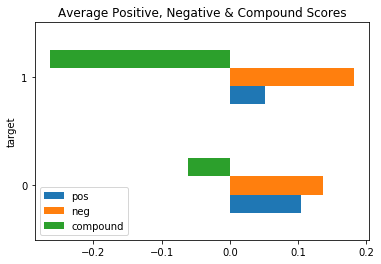

In [23]:
df.groupby('target').mean()[['pos', 'neg', 'compound']].plot(kind='barh')
plt.title('Average Positive, Negative & Compound Scores');

# 1 is real disaster and 0 is fake disaster

# Modeling-Prep

In [24]:
df.head()

,compound,neg,neu,pos,text,target
0,0.2732,0.000,0.851,0.149,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,-0.3400,0.286,0.714,0.000,Forest fire near La Ronge Sask. Canada,1
2,-0.2960,0.095,0.905,0.000,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,0.0000,0.000,1.000,0.000,"13,000 people receive #wildfires evacuation orders in California",1
4,0.0000,0.000,1.000,0.000,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


#### Set up X and y

In [25]:
X = df[['text', 'compound']]
y = df['target']

In [26]:
X.shape

(7613, 2)

In [27]:
#check for balanced classes & baseline

y.value_counts(normalize = True)

0    0.57034
1    0.42966
Name: target, dtype: float64

#### train test split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

(5709, 5)

### Count Vectorizer

In [30]:
cvec = CountVectorizer(stop_words = 'english', max_features = 3000)

X_train_cv = cvec.fit_transform(X_train['text'])
X_test_cv = cvec.transform(X_test['text'])

In [31]:
X_train_cv

<5709x3000 sparse matrix of type '<class 'numpy.int64'>'
	with 35423 stored elements in Compressed Sparse Row format>

#### Create new dataframes for training and test text

In [32]:
df_X_train = pd.DataFrame(X_train_cv.todense(), columns = cvec.get_feature_names())

In [34]:
df_X_test = pd.DataFrame(X_test_cv.todense(), columns = cvec.get_feature_names())

#### Reset Indices

In [36]:
df_X_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
df_X_test.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace=True)

#### Add sentiment scores back to text data. merge on index, drop 'text' column 

In [37]:
X_train_all = pd.concat([df_X_train, X_train], axis =1 )

In [38]:
X_test_all = pd.concat([df_X_test, X_test], axis = 1)

In [39]:
X_test_all.head()

,00,000,01,02,03,04,05,06,07,08,...,ûªt,ûªve,ûï,ûïa,ûïthe,ûïwhen,ûò,ûó,text,compound
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,If I survive tonight. I wouldn't change one thing. ??,0.0000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,I wanna set some shit on fire.,-0.7184
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Reddit's new content policy goes into effect many horrible subreddits banned or quarantined,-0.7579
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Check out this awesome profile on #GE's swimming #robot used in #nuclear reactors! #innovation,0.7325
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,My car is so fast,0.0000


#### Drop Text Column

In [40]:
X_train_all.drop(columns = 'text', inplace = True)
X_test_all.drop(columns = 'text', inplace = True)

#### Checking all my data dimensions

In [41]:
X_train_all.shape, X_test_all.shape

((5709, 3000), (1904, 3000))

In [43]:
X_train_all.head()

,00,000,01,02,03,04,05,06,07,08,...,ûªs,ûªt,ûªve,ûï,ûïa,ûïthe,ûïwhen,ûò,ûó,compound
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5862
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0000
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.2263
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.5461
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.6369


In [44]:
X_test_all.head()

,00,000,01,02,03,04,05,06,07,08,...,ûªs,ûªt,ûªve,ûï,ûïa,ûïthe,ûïwhen,ûò,ûó,compound
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.7184
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-0.7579
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.7325
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0000


In [42]:
y_train.shape, y_test.shape

((5709,), (1904,))

### Modeling Time!

- Some limitations we're currently working with:
    - we only have a few models to choose from right now - we'll have many more next week!
    - We can't use Multinomial Bayes because we have negative numbers from our sentiment scores

In [ ]:
# Instaniate logistic regression

In [45]:
logreg = LogisticRegression()

In [46]:
logreg.fit(X_train_all, y_train)

LogisticRegression()

In [48]:
logreg.score(X_train_all, y_train), logreg.score(X_test_all, y_test)

(0.9036608863198459, 0.8035714285714286)

### Logreg Confusion Matrix 

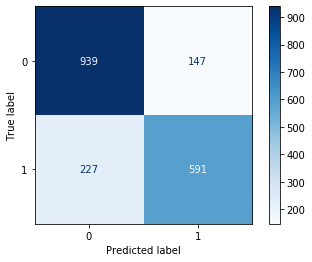

In [49]:
# # Get predictions
preds_logreg = logreg.predict(X_test_all)

# # Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_logreg).ravel()

plot_confusion_matrix(logreg, X_test_all, y_test, cmap='Blues', values_format='d');


### KNN

In [ ]:
# knn = KNeighborsClassifier()

In [ ]:
# knn.fit(X_train_all, y_train)

In [ ]:
# knn.score(X_train_all, y_train), knn.score(X_test_all, y_test)

In [ ]:
# # Get predictions
# preds_knn = knn.predict(X_test_all)

# # Save confusion matrix values
# tn, fp, fn, tp = confusion_matrix(y_test, preds_knn).ravel()

# plot_confusion_matrix(knn, X_test_all, y_test, cmap='Blues', values_format='d');


In [ ]:
# # Calculate the specificity

# spec = tn / (tn + fp)

# print('Specificity:', spec)

### Additional Resources:

Github Resources: https://github.com/cjhutto/vaderSentiment

Academic Paper: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf